# 处理文本数据

## 文本分词
使用Edith Wharton的短篇小说The Verdict作为分词文本。

In [1]:
import urllib.request   # 标准库模块：提供打开URL、下载网络资源的功能

from ntsecuritycon import TokenLinkedToken

url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x198e3cc9bd0>)

通过Python读取短篇小说The Verdict作为文本样本
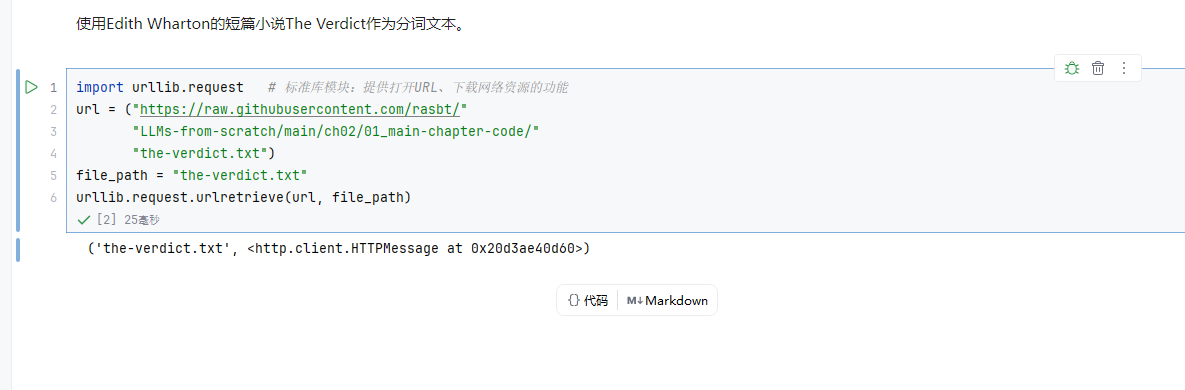

打印(print)命令首先输出该文件的字符总数，然后展示文件的前100个字符作为内容示

In [2]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


我们的目标是将这篇包含20479个字符的短篇小说分割为独立的单词和特殊字符，以便在后续章节中将它们转换为嵌入向量，进而用于大语言模型训练。

In [3]:
# Python的正则表达式库re
import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


运行代码得到的结果是一个包含单个单词、空白字符和标点符号的列表，但问题在于，一些单词仍然与标点符号相连，而我们希望这些标点符号作为单独的列表项。此外，我们没有将所有文本都转换为小写，因为**大写形式有助于大语言模型区分专有名词和普通名词、更好地理解句子结构，并学会正确地生成大写字母**。

In [4]:
# 修改正则表达式，使其在空白字符(\s)、逗号和句号([,.])处进行分割：
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


可以看到，我们如愿地将单词和标点符号分割成了独立的列表项， 一个小问题是列表中仍然包含空白字符。可以通过以下方法安全地删除这些冗余字符：

In [5]:
result = [item for item in result if item.strip()] # 去掉首尾的空格
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


在开发简易分词器时，是将空白字符单独编码还是直接移除，取决于具体的应用场景和需求。移除空白字符可以减轻内存和计算的负担。然而，如果训练的模型需要对文本的精确结构保持敏感，那么保留空白字符就显得尤为重要（例如，Python代码对缩进和空格具有高敏感性）​。为了简化和缩短分词的输出，我们暂时选择移除空白字符。稍后，我们将改为采用保留空白字符的分词方案。

我们设计的分词方法在处理简单文本时表现良好。接下来，让我们再修改一下，使其能够处理其他类型的标点符号，比如问号、引号，以及短篇小说The Verdict的前100个字符中出现的双破折号等特殊字符：

In [6]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


我们已经构建了一个简易分词器，让我们将其应用于短篇小说The Verdict的全文：

In [7]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


上述打印语句的输出是4690，这是该文本的词元数量（不包括空白字符）​。为了快速查看分词效果，可以打印前30个词元：

In [8]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## 将词元转换为词元ID

把这些词元从Python字符串转换为整数表示，以生成词元ID(token ID)。

为了将先前生成的词元映射到词元ID，首先需要构建一张词汇表。这张词汇表定义了如何将每个唯一的单词和特殊字符映射到一个唯一的整数。

首先将训练集中的全部文本分词成独立的词元；然后将这些词元按字母顺序进行排列，并删除重复的词元；接下来将唯一的词元聚合到一张词汇表中，该词汇表定义了每个唯一的词元到唯一的整数值的映射。为简单起见，这里所展示的词汇表特意设置得很小，并且不包含标点符号和特殊字符。

现在我们已经完成了短篇小说The Verdict的分词，并将结果存储在名为preprocessed的Python变量中。接下来，我们将创建一个包含所有唯一词元的列表，并将它们按照字母顺序排列，以确定词汇表的大小：

In [9]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


随后，我们创建词汇表，并打印该词汇表的前51个条目作为示例

In [10]:
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


分词器通常包含两个常见的方法：encode方法和decode方法。encode方法接收文本样本，将其分词为单独的词元，然后再利用词汇表将词元转换为词元ID。而decode方法接收一组词元ID，将其转换回文本词元，并将文本词元连接起来，形成自然语言文本。

In [11]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join(self.int_to_str[i] for i in ids)
        text = re.sub(r'\s+([,.?!"()\'])',r'\1', text)
        return text

让我们创建一个SimpleTokenizerV1类的分词器实例对象，并将其应用于短篇小说The Verdict中的一段文本，试试看分词器的实际效果：

In [12]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know,"
       Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [13]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


我们实现了一个能够基于训练集对文本进行分词和反分词的分词器。现在，将这个分词器应用于训练集之外的新样本：

In [14]:
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

问题在于，“Hello”这一单词并未在短篇小说The Verdict中出现，因此没有被收录到词汇表中。这一现象凸显了在处理大语言模型时，使用规模更大且更多样化的训练集来扩展词汇表的必要性。

## 2.4 引入特殊上下文词元

为了处理未知的单词，需要对分词器进行必要的修改。接下来，我们将探讨如何通过引入特殊上下文词元，来增强模型对上下文和其他相关信息的理解。这些特殊词元可能包括用于标识未知词汇和文档边界的词元。现在，我们将修改2.3节中实现的词汇表和分词器SimpleTokenizerV2，以支持两个新词元—<|unk|>和<|endoftext|>。

* <|unk|>词元来表示那些未出现在训练数据中，因而没有被包含在现有词汇表中的新词和未知词。
* <|endoftext|>词元来分隔两个不相关的文本来源

在处理多个独立的文本源时，我们在这些文本之间插入<|endoftext|>词元。这些<|endoftext|>词元作为标记，可以指示出特定文本片段的开始或结束，从而有助于大语言模型更有效地处理和理解文本。

现在，将这两个特殊词元<unk>和<|endoftext|>添加到词汇表中：

In [22]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}

print(len(vocab.items()))

1132


为了进行快速验证，打印新的词汇表的最后5个条目：

In [23]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


接下来，我们将基于代码清单2-3对分词器进行调整，详见代码清单2-4

In [24]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join(self.int_to_str[i] for i in ids)
        text = re.sub(r'\s+([,.?!"()\'])',r'\1', text)
        return text

现在来实际测试一下这个新的分词器。为此，我们将使用一个简单的文本样本，该样本由两个独立且无关的句子拼接而成：

In [25]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [26]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


观察词元ID列表，可以发现它包含了一个表示<|endoftext|>分隔符的1130词元，以及两个表示未知单词的1131词元。

让我们对其进行反词元化处理，来快速检查分词器的有效性

In [27]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


在不同的大语言模型中，研究人员可能会考虑引入如下这些特殊词元。

* [BOS]（序列开始）：标记文本的起点，告知大语言模型一段内容的开始。
* [EOS]（序列结束）：位于文本的末尾，类似<|endoftext|>，特别适用于连接多个不相关的文本。例如，在合并两篇不同的维基百科文章（或两本不同的图书）时，[EOS]词元指示一篇文章的结束和下一篇文章的开始。
* [PAD]（填充）：当使用批次大小(batch size)大于1的批量数据训练大语言模型时，数据中的文本长度可能不同。为了使所有文本具有相同的长度，较短的文本会通过添加[PAD]词元进行扩展或“填充”，以匹配批量数据中的最长文本的长度。值得注意的是，GPT模型使用的分词器并不依赖这些特殊词元，而是仅使用<|endoftext|>词元来简化其处理流程。<|endoftext|>词元与[EOS]词元作用相似。此外，<|endoftext|>也被用于文本的填充。然而，正如本书后面章节中将要探讨的那样，当模型在批量输入上进行训练时，我们通常使用掩码技术，这意味着我们并不会关注那些仅用于填充的词元。因此，具体选择哪种词元来进行填充实际上并不重要。

此外，GPT模型的分词器也不使用<|unk|>词元来处理超出词汇表范围的单词，而是使用BPE分词器将单词拆解为子词单元

## BPE   Byte Pair Encoding

我们将使用现有的Python开源库tiktoken，它基于Rust的源代码非常高效地实现了BPE算法。与其他Python库类似，可以通过Python的pip安装器从终端安装tiktoken库：

In [15]:
pip install tiktoken

   ---------------------------------------- 0.0/879.1 kB ? eta -:--:--
   ---------------------------------------- 879.1/879.1 kB 29.7 MB/s  0:00:00

   ---------------------------------------- 2/2 [tiktoken]

Note: you may need to restart the kernel to use updated packages.


In [15]:
from importlib_metadata import version
import tiktoken
print("tiktoken version : ", version("tiktoken"))

tiktoken version :  0.12.0


实例化tiktoken中的BPE分词器

In [16]:
tokenizer = tiktoken.get_encoding("gpt2")

这个分词器与前面通过encode方法实现的SimpleTokenizerV2用法相似：

In [17]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [18]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


第一，<|endoftext|>词元被分配了一个较大的词元ID，即50256。事实上，用于训练GPT-2、GPT-3和ChatGPT中使用的原始模型的BPE分词器的词汇总量为50 257，这意味着<|endoftext|>被分配了最大的词元ID。

第二，BPE分词器可以正确地编码和解码未知单词，比如“someunknownPlace”。BPE分词器是如何做到在不使用<|unk|>词元的前提下处理任何未知词汇的呢？

BPE算法的原理是将不在预定义词汇表中的单词分解为更小的子词单元甚至单个字符，从而能够处理词汇表之外的单词。因此，得益于BPE算法，如果分词器在分词过程中遇到不熟悉的单词，它可以将其表示为子词词元或字符序列，如图2-11所示。

练习2.1 未知单词的BPE

尝试使用tiktoken库中的BPE分词器对未知单词“Akwirw ier”进行分词，并打印所有词元ID。然后，对得到的列表中的每个整数应用decode函数，以重现图2-11中的映射。最后，对这些词元ID调用decode方法，检查它能否还原原始输入“Akwirw ier”。

In [20]:
import tiktoken

# 1) 选择一个常用的 BPE 编码
enc = tiktoken.get_encoding("gpt2")

# 2) 未知词
text11 = "Akwirwier"

# 3) BPE 编码 -> token id 序列
ids11 = enc.encode(text11)
print("Token IDs:", ids11)


# 4) 逐个 token id 解码，观察每个子串（Fig 2-11 那种“映射表”效果）
print("ID -> piece 映射：")
for tid in ids11:
    piece = enc.decode([tid])
    print(f"{tid:>6} -> {repr(piece)}")

# 5) 把整串 id 再 decode 回原字符串，检验可逆性
reconstructed = enc.decode(ids11)
print("Reconstructed:", reconstructed)
print("Match:", reconstructed == text11)

Token IDs: [33901, 86, 343, 86, 959]
ID -> piece 映射：
 33901 -> 'Ak'
    86 -> 'w'
   343 -> 'ir'
    86 -> 'w'
   959 -> 'ier'
Reconstructed: Akwirwier
Match: True


BPE通过将频繁出现的字符合并为子词，再将频繁出现的子词合并为单词，来迭代地构建词汇表。具体来说，BPE首先将所有单个字符（如“a”“b”等）添加到词汇表中。然后，它会将频繁同时出现的字符组合合并为子词。例如，“d”和“e”可以合并为子词“de”，这是“define”“depend”“made”“hidden”等许多英语单词中的常见组合。字符和子词的合并由一个频率阈值来决定。

In [ ]:
## 使用滑动窗口进行数据采样

In [21]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


从数据集中移除前50个词元以便演示，这样做会使得在后续步骤中产生一个更有趣一些的文本段落：

In [23]:
enc_sample = enc_text[:50]
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x : {x}")
print(f"y :     {y}")

x : [40, 367, 2885, 1464]
y :     [367, 2885, 1464, 1807]


In [24]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[40] ----> 367
[40, 367] ----> 2885
[40, 367, 2885] ----> 1464
[40, 367, 2885, 1464] ----> 1807


箭头(---->)左侧的内容表示大语言模型接收的输入，箭头右侧的词元ID则代表大语言模型应该预测的目标词元ID。为了更直观地展示这一过程，让我们重用前面的代码，但这一次将词元ID转换回文本形式：

In [25]:
for i in range(1, context_size+1):
   context = enc_sample[:i]
   desired = enc_sample[i]
   print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

I ---->  H
I H ----> AD
I HAD ---->  always
I HAD always ---->  thought


可用于大语言模型训练的输入-目标对就创建好了。

在将词元转化为嵌入向量前，还需要完成最后一项任务：实现一个高效的数据加载器(data loader)。这个数据加载器会遍历输入数据集，并将输入和目标以PyTorch张量的形式返回，这些PyTorch张量可以被视为多维数组。具体来说，我们的目标是返回两个张量：一个是包含大语言模型所见的文本输入的输入张量，另一个是包含大语言模型需要预测的目标词元的目标张量

In [36]:
# 一个用于批处理输入和目标的数据集

import  torch
from torch.utils.data import Dataset, DataLoader, DataLoader

class GPTDatasetV1(Dataset):
    # max_length：每个样本（序列）的固定长度。
    # stride：滑动窗口步长；步长越小，重叠越多。
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk  = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


GPTDatasetV1类继承自PyTorch的Dataset类，并定义了如何从数据集中提取单行数据。每行数据包含多个词元ID（数量由max_length参数决定）​，这些词元ID被分配给input_chunk张量，而target_chunk张量包含相应的目标词元ID。


In [37]:
def create_dataloader_v1(
    txt,
    batch_size=4,
    max_length=256,
    stride=128,
    shuffle=True,
    drop_last=True,
    num_workers=0,
):
    tokenizer = tiktoken.get_encoding("gpt2")      # 选一个BPE词表（要全流程一致）
    dataset   = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,   # 每批样本数
        shuffle=shuffle,         # 每个 epoch 是否打乱样本顺序
        drop_last=drop_last,     # 最后一批不满 batch_size 时是否丢弃
        num_workers=num_workers  # 后台数据预处理的CPU进程数（>0 开多进程）
    )
    return dataloader


用批次大小为1的DataLoader对上下文长度为4的大语言模型进行测试，以便直观理解代码清单2-5中的GPTDatasetV1类和代码清单2-6中的create_dataloader_v1函数是如何协同工作的：

In [38]:

with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)



[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


变量first_batch包含两个张量：第一个张量存储输入词元ID，第二个张量存储目标词元ID。由于max_length被设置为4，因此这两个张量各自包含4个词元ID。需要注意的是，为简单起见，我们将输入大小设置为4，但这个数值是非常小的。在实际训练大语言模型时，输入大小通常不小于256。

为了说明stride=1的含义，需要从该数据集中获取另一批数据：

In [39]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


如果将第一批数据与第二批数据进行比较，可以发现第二批数据的词元ID相对于第一批整体左移了一个位置。

步幅(stride)决定了批次之间输入的位移量，模拟了滑动窗口方法。

练习2.2 具有不同步幅和上下文长度的数据加载器

为了更直观地了解数据加载器的工作原理，请尝试使用不同的参数设置来运行它，比如max_length=2, stride=2和max_length=8, stride=2。


In [43]:
# --- 情况1：max_length=2, stride=2 ---
loader = create_dataloader_v1(raw_text, batch_size=1, max_length=2, stride=2, shuffle=False)
it = iter(loader)
for k in range(3):                      # 只看前三个窗口
    x, y = next(it)                     # DataLoader -> iterator -> next
    print(k, x[0].tolist(), '->', y[0].tolist())

# --- 情况2：max_length=8, stride=2 ---
loader = create_dataloader_v1(raw_text, batch_size=1, max_length=8, stride=2, shuffle=False)
it = iter(loader)                       # 记得重新获取一个新的迭代器
for k in range(3):
    x, y = next(it)
    print(k, x[0].tolist(), '->', y[0].tolist())


0 [40, 367] -> [367, 2885]
1 [2885, 1464] -> [1464, 1807]
2 [1807, 3619] -> [3619, 402]
0 [40, 367, 2885, 1464, 1807, 3619, 402, 271] -> [367, 2885, 1464, 1807, 3619, 402, 271, 10899]
1 [2885, 1464, 1807, 3619, 402, 271, 10899, 2138] -> [1464, 1807, 3619, 402, 271, 10899, 2138, 257]
2 [1807, 3619, 402, 271, 10899, 2138, 257, 7026] -> [3619, 402, 271, 10899, 2138, 257, 7026, 15632]


到目前为止，我们从数据加载器中采样的批次大小为1，该设置有益于进行演示。如果你在深度学习方面有所心得，那么可能会意识到较小的批次大小会减少训练过程中的内存占用，但同时会导致在模型更新时产生更多的噪声。正如在常规深度学习训练中一样，批次大小同样是训练大语言模型时需要仔细权衡并尝试调整的超参数。

简单了解一下，如何以大于1的批次大小使用数据加载器进行采样：

In [44]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4,
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


值得说明的是，我们选择将步幅增加到4来充分利用数据集（不会跳过任何一个单词），同时避免不同批次之间的数据重叠，因为过多的重叠可能会增加模型过拟合的风险。

## 2.7 创建词元嵌入